In [1]:
import sys
import os
import SimpleITK as sitk
import detectron2.model_zoo
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import json
import numpy as np
import gc

import torch
from detectron2.checkpoint import DetectionCheckpointer

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from fvcore.transforms import TransformList
from numpy.f2py.auxfuncs import throw_error

In [2]:
# Load the Excel file with the metadata of the LIDC-IDRI dataset
valid_series_ids = pd.read_excel(os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332", "TCIA_LIDC-IDRI_20200921-nbia-digest.xlsx"))

# Filter the valid series IDs to only include the Modality = CT
valid_series_ids = valid_series_ids[valid_series_ids["Modality"] == "CT"]["Series Instance UID"].tolist()

In [3]:
"""
    Get the paths to the DICOM folders in the LIDC-IDRI dataset.
    :param basePath: The base path to the LIDC-IDRI dataset.
    :return: A list of paths to the DICOM folders.
"""
def get_dicom_folders_LIDC(basePath: str) -> dict:
    dicom_folders = os.listdir(basePath)

    if "LICENSE" in dicom_folders:
        dicom_folders.remove("LICENSE")

    scan_paths = dict()

    # Go through the base paths to find any scans within the TCIA file and add these into the scan paths dictionary
    for dicom_folder in dicom_folders:
        folder_path = os.path.join(basePath, dicom_folder)
        if not os.path.isdir(folder_path):
            continue

        for study in os.listdir(folder_path):
            study_path = os.path.join(folder_path, study)
            if not os.path.isdir(study_path):
                continue

            for series in os.listdir(study_path):
                series_path = os.path.join(study_path, series)
                if not os.path.isdir(series_path):
                    continue

                try:
                    # Extract the series uid from the first dicom file in each end path
                    sample_file = next(f for f in os.listdir(series_path) if f.lower().endswith(".dcm"))
                    dicom_data = pydicom.dcmread(os.path.join(series_path, sample_file), stop_before_pixels=True)
                    series_uid = dicom_data.SeriesInstanceUID

                    # Only add scans which are valid
                    if series_uid in valid_series_ids:
                        scan_paths[series_uid] = series_path
                except Exception as e:
                    print(f"Could not read SeriesInstanceUID from {series_path}: {e}")

    return scan_paths

def get_luna_subset_mhd_paths(basePath: str) -> list:
    # Get the path to the LUNA16 dataset
    subset_folders = os.listdir(basePath)

    mhd_file_paths = dict()

    for folder in subset_folders:
        # Loop through all subset folders and add the path and series_uid to the dictionary
        if folder.startswith("subset"):
            subset_path = os.path.join(basePath, folder)
            mhd_files = os.listdir(subset_path)

            for file in mhd_files:
                if file.endswith(".mhd"):
                    # Get the series UID from the filename
                    series_uid = file[:-4]
                    mhd_file_paths[series_uid] = os.path.join(subset_path, file)

    return mhd_file_paths

In [12]:
from typing import Dict, List
import random
import cv2

TARGET_SPACING = [1.0, 1.0, 1.0]
# Standard windowing values for chest CT
WINDOW_LEVEL = -600
WINDOW_WIDTH = 1500
BASE_OUTPUT_DIR = os.path.join(os.getcwd(), "processed_data")

def resample(image: sitk.Image, new_spacing: tuple) -> sitk.Image:
    # Get the original spacing
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    original_physical_size = [original_size[i] * original_spacing[i] for i in range(3)]
    new_size = [int(round(original_physical_size[i] / new_spacing[i])) for i in range(3)]

    # Resample the image
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image.GetDirection())
    resampler.SetOutputOrigin(image.GetOrigin())
    resampler.SetTransform(sitk.Transform())

    pixel_id_value = image.GetPixelID()
    default_value = -1000

    if pixel_id_value == sitk.sitkFloat32 or pixel_id_value == sitk.sitkFloat64:
         default_value = -1000.0
    resampler.SetDefaultPixelValue(default_value)

    resampled_image = resampler.Execute(image)

    return resampled_image

def apply_windowing(image: np.array, window_center: int, window_width: int) -> np.array:
    # Apply windowing to the image
    min_intensity = window_center - (window_width / 2.0)
    max_intensity = window_center + (window_width / 2.0)

    # Clip the image to the window
    image = np.clip(image, min_intensity, max_intensity)

    return image

def normalize(image: np.array) -> np.array:
    min_val = np.min(image)
    max_val = np.max(image)

    # Normalize the image to the range [0, 1]
    if max_val - min_val > 0:
        # Avoid division by zero
        image = (image - min_val) / (max_val - min_val)
    else:
        image = np.zeros_like(image)

    return image

def extract_axial_slices(image: np.ndarray,
    output_dir: str,
    scan_id: str = "scan") -> None:

    # Don't save anything if there are no nodules in the scan
    num_slices = image.shape[0]
    os.makedirs(output_dir, exist_ok=True)

    for slice_idx in range(num_slices):
        img_slice = image[slice_idx]
        norm_slice = (img_slice - np.min(img_slice)) / (np.ptp(img_slice) + 1e-5)
        slice_uint8 = (norm_slice * 255).astype(np.uint8)

        image_filename = f"{scan_id}_slice_{slice_idx:04d}.png"

        img_path = os.path.join(output_dir, image_filename)

        try:
            cv2.imwrite(img_path, slice_uint8)
        except Exception as e:
            print(f"  Warning: Failed to save PNG slice {img_path}: {e}")
            continue

def convert_to_yolo_format(bbox, img_width, img_height):
    """Convert bbox from [x1, y1, x2, y2] to YOLO [x_center, y_center, w, h], normalized."""
    x1, y1, x2, y2 = bbox
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height
    return [0, x_center, y_center, width, height]  # class 0 for nodule

def extract_yolo_style_slices(
    image: np.ndarray,
    output_dir: str,
    annotations: Dict[int, List[List[float]]] = None,
    scan_id: str = "scan",
    neighbor_offsets: List[int] = [-1, 0, 1],
    add_random_negatives: bool = True,
    num_random_negatives: int = 10
):
    height, width = image.shape[1:]
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

    # Prepare a dict to hold final annotations for each slice
    combined_annotations = {}

    # Propagate annotations to neighbors
    for center_idx, bboxes in (annotations or {}).items():
        for offset in neighbor_offsets:
            slice_idx = center_idx + offset
            if 0 <= slice_idx < image.shape[0]:
                if slice_idx not in combined_annotations:
                    combined_annotations[slice_idx] = []
                combined_annotations[slice_idx].extend(bboxes)

    used_indices = sorted(combined_annotations.keys())

    # Save positive/neighbor slices with annotations
    for slice_idx in used_indices:
        img_slice = image[slice_idx]
        norm_slice = (img_slice - np.min(img_slice)) / (np.ptp(img_slice) + 1e-5)
        slice_uint8 = (norm_slice * 255).astype(np.uint8)

        image_filename = f"{scan_id}_slice_{slice_idx:04d}.png"
        label_filename = f"{scan_id}_slice_{slice_idx:04d}.txt"

        img_path = os.path.join(output_dir, 'images', image_filename)
        label_path = os.path.join(output_dir, 'labels', label_filename)

        cv2.imwrite(img_path, slice_uint8)

        boxes = combined_annotations.get(slice_idx, [])
        with open(label_path, 'w') as f:
            for box in boxes:
                yolo_box = convert_to_yolo_format(box, width, height)
                f.write(" ".join([str(round(x, 6)) for x in yolo_box]) + "\n")

    # Add background (negative) slices
    if add_random_negatives:
        all_indices = set(range(image.shape[0]))
        unused_indices = list(all_indices - set(used_indices))
        if len(unused_indices) < num_random_negatives:
            print(f"  Only {len(unused_indices)} negatives available, reducing sample count.")
            num_random_negatives = len(unused_indices)

        negative_samples = random.sample(unused_indices, num_random_negatives)
        for slice_idx in negative_samples:
            img_slice = image[slice_idx]
            norm_slice = (img_slice - np.min(img_slice)) / (np.ptp(img_slice) + 1e-5)
            slice_uint8 = (norm_slice * 255).astype(np.uint8)

            image_filename = f"{scan_id}_slice_{slice_idx:04d}.png"
            label_filename = f"{scan_id}_slice_{slice_idx:04d}.txt"

            img_path = os.path.join(output_dir, 'images', image_filename)
            label_path = os.path.join(output_dir, 'labels', label_filename)

            cv2.imwrite(img_path, slice_uint8)

            # Write an empty label file
            with open(label_path, 'w') as f:
                pass


"""
Preprocess the image by resampling, applying windowing, and normalizing.
Extract the axial slices and save them as .npy files.
:param image: The input image to preprocess.
:return: None
"""
def preprocess_image(series_uid: str, image: sitk.Image, annotations: pd.DataFrame = None, patient_id: str = "UnknownPatient") -> None:
    # Preprocess the image
    resampled_image = resample(image, TARGET_SPACING)
    resampled_size = resampled_image.GetSize() # Needed for bounds check
    resampled_spacing = resampled_image.GetSpacing() # Needed for bbox calculation

    slice_annotations = {} # dict to hold slice annotations

    # For each nodule, get nodule world coordinates and diameter
    # Convert world coordinates to voxel coordinates (continuous) using origin, spacing, direction of resampled image
    if annotations is not None and not annotations.empty:
        for index, row in annotations.iterrows():
            # Get the nodule world coordinates and diameter
            nodule_world_coords = (row["coordX"], row["coordY"], row["coordZ"])
            nodule_diameter = row["diameter_mm"]

            try:
                continuous_voxel_index_xyz = resampled_image.TransformPhysicalPointToContinuousIndex(nodule_world_coords)
            except Exception as TfmEx: continue # Skip is the transform fails

            vx, vy, vz = continuous_voxel_index_xyz

            # Only assign the bounding box to the closest slice to the nodule center
            # This is simpler to implement and models can still usually learn effectively
            # Could calculate the Z-extent using radius_vz = diamter / 2.0 / spacing[2] and add this to previous and next slices
            # to have the same bounding box for multiple slices but this is not implemented here due to complexity.
            slice_index_z = int(round(vz))

            # Check if voxel index is within the resampled volume bounds
            if not (0 <= slice_index_z < resampled_size[2] and
                    0 <= int(round(vy)) < resampled_size[1] and
                    0 <= int(round(vx)) < resampled_size[0]):
                 continue

            # Calculate radius and bounding box pixel coordinates using X, Y, Z space ordering from simpleITK
            radius_vx = int(round(nodule_diameter / 2.0 / resampled_spacing[0]))
            radius_vy = int(round(nodule_diameter / 2.0 / resampled_spacing[1]))

            # Calculate the bounding box pixel coordinates
            x_min = int(round(vx - radius_vx))
            x_max = int(round(vx + radius_vx))
            y_min = int(round(vy - radius_vy))
            y_max = int(round(vy + radius_vy))

            # Clip to slice bounds, use X, Y, Z ordering
            image_height = resampled_size[1]
            image_width = resampled_size[0]

            x_min = max(x_min, 0)
            x_max = min(x_max, image_width - 1)
            y_min = max(y_min, 0)
            y_max = min(y_max, image_height - 1)

            # Check if valid bounding box
            if x_min < x_max and y_min < y_max:
                bbox = [x_min, y_min, x_max, y_max]
                if slice_index_z not in slice_annotations:
                    slice_annotations[slice_index_z] = []
                slice_annotations[slice_index_z].append(bbox)

    resampled_np = sitk.GetArrayFromImage(resampled_image)

    windowed_image = apply_windowing(resampled_np, -600, 1500)
    normalized_image = normalize(windowed_image)

    if annotations:
        output_slices_dir = os.path.join(BASE_OUTPUT_DIR, "processed_slices", patient_id, series_uid)
        extract_yolo_style_slices(normalized_image, output_slices_dir, slice_annotations, patient_id)
    else:
        output_slices_dir = os.path.join(BASE_OUTPUT_DIR, "processed_slices", "LIDC", patient_id, series_uid)
        extract_axial_slices(normalized_image, output_slices_dir, series_uid)



In [5]:
lidc_dict = get_dicom_folders_LIDC(os.path.join(os.getcwd(), "LIDC-IDRI", "manifest-1743272998332",
                          "LIDC-IDRI"))

luna_dict = get_luna_subset_mhd_paths(os.path.join(os.getcwd(), "LUNA16"))

annotations = pd.read_csv(os.path.join(os.getcwd(), "LUNA16", "annotations.csv"))

In [10]:
def load_and_preprocess_dataset(path_dict: dict, dataset_name: str, all_annotations_df: pd.DataFrame = None): # Use dataset_name
    """
    Loads and preprocesses a dataset (LIDC-IDRI or LUNA16) scan by scan.

    Args:
        path_dict: Dictionary mapping series_uid to file/directory path.
        dataset_name: String, either "LIDC-IDRI" or "LUNA16".
        all_annotations_df: Full pandas DataFrame of LUNA16 annotations (required if dataset_name is "LUNA16").
    """
    print(f"\n Processing {dataset_name} Scans ({len(path_dict)} found)")
    processed_count = 0
    error_count = 0
    skipped_count = 0
    is_luna_flag = (dataset_name == "LUNA16") # Determine flag based on name

    if is_luna_flag and all_annotations_df is None:
        print("Error: Annotations DataFrame must be provided when processing LUNA16.")
        return # Or raise an error

    for i, (series_uid, file_or_dir_path) in enumerate(path_dict.items()):
        image_itk = None
        patient_id = "UnknownPatient"
        try:
            # Try extracting like LIDC-IDRI-XXXX from the path
            path_parts = file_or_dir_path.replace('\\', '/').split('/') # Normalize separators
            patient_part = next((part for part in reversed(path_parts) if part.startswith("LIDC-IDRI-")), None)
            if patient_part:
                patient_id = patient_part
            elif is_luna_flag:
                # Extract everything between the last 2 full stops as the series_uid
                end_series_uid = file_or_dir_path.split(".")[-2]
                patient_id = f"LUNA_{end_series_uid}"
        except Exception:
             end_series_uid = file_or_dir_path.split(".")[-2]
             patient_id = f"UnknownPatient_{end_series_uid}" # Fallback (unreliable)

        try:
            if is_luna_flag:
                # Load MHD file for LUNA
                if not os.path.isfile(file_or_dir_path): # Check if it's a file
                    print(f"  Skipping: LUNA MHD path not found or is not a file: {file_or_dir_path}")
                    skipped_count += 1
                    continue
                image_itk = sitk.ReadImage(file_or_dir_path) # Read the image file
            else: # Processing LIDC
                # Load DICOM series directory
                if not os.path.isdir(file_or_dir_path): # Check if it's a directory
                    print(f"  Skipping: LIDC DICOM path not found or is not a directory: {file_or_dir_path}")
                    skipped_count += 1
                    continue
                reader = sitk.ImageSeriesReader()
                reader.SetImageIO("GDCMImageIO")
                dicom_names = reader.GetGDCMSeriesFileNames(file_or_dir_path)
                if not dicom_names:
                    skipped_count += 1
                    continue
                reader.SetFileNames(dicom_names)
                image_itk = reader.Execute() # Read the series directory

            annotations_to_pass = None
            if is_luna_flag: # Only need annotations for LUNA fine-tuning/eval data
                annotations_to_pass = all_annotations_df[all_annotations_df['seriesuid'] == series_uid]
                if annotations_to_pass.empty:
                     annotations_to_pass = None # Explicitly pass None if no annotations found

            # Preprocess the loaded image
            if image_itk:
                preprocess_image(
                    series_uid,
                    image_itk,
                    annotations=annotations_to_pass,
                    patient_id=patient_id
                )
                processed_count += 1
            else:
                 print(f"  Skipping: Failed to load image for {series_uid} (Should have been caught earlier)")
                 skipped_count += 1

            del image_itk
            del annotations_to_pass

        except Exception as e:
            print(f"!! Major Error processing series {series_uid} at path {file_or_dir_path}: {e}")
            error_count += 1

            try: del image_itk
            except: pass
            try: del annotations_to_pass
            except: pass

        if (i+1) % 10 == 0:
            # Force garbage collection every 10 iterations to free up memory
            gc.collect()
            print(f"  Garbage collection triggered after processing {i+1} scans.")

        print(f"  Processed {processed_count} / {len(path_dict)}: {series_uid} ({dataset_name})")

    # --- Summary Print ---
    print(f"Finished processing {dataset_name}")
    print(f"Successfully preprocessed: {processed_count}")
    print(f"Skipped (Path/Read Error): {skipped_count}")
    print(f"Errors during processing: {error_count}")
    gc.collect()

In [13]:
load_and_preprocess_dataset(lidc_dict, dataset_name="LIDC-IDRI", all_annotations_df=None)


===== Processing LIDC-IDRI Scans (1018 found) =====
  Processed 1 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192 (LIDC-IDRI)
  Processed 2 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919 (LIDC-IDRI)
  Processed 3 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264 (LIDC-IDRI)
  Processed 4 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228 (LIDC-IDRI)
  Processed 5 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225 (LIDC-IDRI)
  Processed 6 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957 (LIDC-IDRI)
  Processed 7 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.272348349298439120568330857680 (LIDC-IDRI)
  Processed 8 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.774060103415303828812229821954 (LIDC-IDRI)
  Processed 9 / 1018: 1.3.6.1.4.1.14519.5.2.1.6279.6001.286061375572911414226912429210 (LIDC-IDRI)
  Garbage collection triggered after processing 10 scans

In [42]:
load_and_preprocess_dataset(luna_dict, dataset_name="LUNA16", all_annotations_df=annotations)


===== Processing LUNA16 Scans (887 found) =====
  Processed 1 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.105756658031515062000744821260 (LUNA16)
  Processed 2 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.108197895896446896160048741492 (LUNA16)
  Processed 3 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059 (LUNA16)
  Processed 4 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.111172165674661221381920536987 (LUNA16)
  Processed 5 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.122763913896761494371822656720 (LUNA16)
  Processed 6 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.124154461048929153767743874565 (LUNA16)
  Processed 7 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126121460017257137098781143514 (LUNA16)
  Processed 8 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.126264578931778258890371755354 (LUNA16)
  Processed 9 / 887: 1.3.6.1.4.1.14519.5.2.1.6279.6001.128023902651233986592378348912 (LUNA16)
  Garbage collection triggered after processing 10 scans.
  Processed 10 / 887: 1.3.6.1.4.1.1451

In [12]:
import os
import random
import shutil
from pathlib import Path
from collections import defaultdict

def gather_image_label_pairs(root_dir):
    image_label_pairs = []
    for subdir, _, _ in os.walk(root_dir):
        if "images" in subdir:
            image_dir = Path(subdir)
            label_dir = image_dir.parent / "labels"
            for img_file in image_dir.glob("*.png"):
                label_file = label_dir / (img_file.stem + ".txt")
                if label_file.exists():
                    image_label_pairs.append((img_file, label_file))
    return image_label_pairs

def extract_scan_uid(filename: str) -> str:
    # Extracts UID: e.g., LUNA_100225287222365663678666836860_slice_0141.png
    return filename.split("_slice_")[0].replace("LUNA_", "")

def split_yolo_dataset_by_scan(source_root, output_root, train_ratio=0.8, val_ratio=0.1, seed=42):
    random.seed(seed)

    all_pairs = gather_image_label_pairs(source_root)

    # Group by scan UID
    scan_to_pairs = defaultdict(list)
    for img_path, lbl_path in all_pairs:
        scan_uid = extract_scan_uid(img_path.name)
        scan_to_pairs[scan_uid].append((img_path, lbl_path))

    # Split by scan UID
    all_scan_uids = list(scan_to_pairs.keys())
    random.shuffle(all_scan_uids)

    n = len(all_scan_uids)
    n_train = int(train_ratio * n)
    n_val = int(val_ratio * n)
    n_test = n - n_train - n_val

    train_uids = all_scan_uids[:n_train]
    val_uids = all_scan_uids[n_train:n_train + n_val]
    test_uids = all_scan_uids[n_train + n_val:]

    def copy_pairs(pairs, split):
        img_out = Path(output_root) / split / "images"
        lbl_out = Path(output_root) / split / "labels"
        img_out.mkdir(parents=True, exist_ok=True)
        lbl_out.mkdir(parents=True, exist_ok=True)

        for img_path, lbl_path in pairs:
            shutil.copy(img_path, img_out / img_path.name)
            shutil.copy(lbl_path, lbl_out / lbl_path.name)

    # Flatten pairs
    train_pairs = [pair for uid in train_uids for pair in scan_to_pairs[uid]]
    val_pairs = [pair for uid in val_uids for pair in scan_to_pairs[uid]]
    test_pairs = [pair for uid in test_uids for pair in scan_to_pairs[uid]]

    # Copy to output
    copy_pairs(train_pairs, "train")
    copy_pairs(val_pairs, "val")
    copy_pairs(test_pairs, "test")

source_dir = r"C:\Users\peter\Masters\Project\processed_data\processed_slices"
output_dir = r"C:\Users\peter\Masters\Project\yolo_split"  # output is safe here

split_yolo_dataset_by_scan(source_dir, output_dir)


✅ Dataset split complete:
  Train: 9888 slices from 709 scans
  Val:   1186 slices from 88 scans
  Test:  1264 slices from 90 scans


In [5]:
annotations = pd.read_csv(os.path.join(os.getcwd(), "LUNA16", "evaluationScript", "annotations", "seriesuids.csv"), header=None)

# Check the luna_ folders to see which series_uids are in the annotations folder but not the processed_slices folder
luna_folders = os.listdir(os.path.join(os.getcwd(), "processed_data", "processed_slices"))
luna_folders = [folder for folder in luna_folders if folder.startswith("LUNA_")]
luna_series_uids = [folder[5:] for folder in luna_folders]

annotations_series_uids = annotations[0].tolist()
annotations_end_uids = [series_uid.split(".")[-1] for series_uid in annotations_series_uids]

missing_series_uids = set(annotations_end_uids).difference(set(luna_series_uids))
print("Missing series UIDs: ", missing_series_uids)
print(len(set(annotations_end_uids)))
print(len(luna_series_uids))

#Print duplicare series UIDs
duplicates = set([series_uid for series_uid in annotations_end_uids if annotations_end_uids.count(series_uid) > 1])
print("Duplicate series UIDs: ", duplicates)

Missing series UIDs:  set()
888
888
Duplicate series UIDs:  set()


In [6]:
def show_slice_with_bboxes(slice_folder: str, series_uid: str):
    slice_file = np.load(os.path.join(os.getcwd(),"processed_data","processed_slices", slice_folder, series_uid, "slices.npz"))
    json_file = os.path.join(os.getcwd(),"processed_data","processed_slices", slice_folder, series_uid, "annotations.json")

    slice_key = None
    slice_filename = None

    bboxes = []

    try:
        with open(json_file) as f:
            annotations = json.load(f)

            # Get the non empty slice key from the json file
            for key in annotations.keys():
                if len(annotations[key]) > 0:
                    slice_key = key
                    slice_filename = key.split(".")[0] # Get the slice filename without the .npy extension
                    print(slice_key)
                    print(slice_filename)
                    bboxes = annotations[key]

                    break

        if slice_key is None:
            print("Error: No annotations found in JSON file")
            return
    except FileNotFoundError:
        print("Error: JSON file not found")
        return
    except Exception as e:
        print(f"Error: {e}")
        return

    slice = slice_file[slice_filename]

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(slice, cmap='gray', origin='upper')

    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.title("Slice with Annotations")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

show_slice_with_bboxes("LUNA_100225287222365663678666836860", "1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\peter\\Masters\\Project\\processed_data\\processed_slices\\LUNA_100225287222365663678666836860\\1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222365663678666836860\\slices.npz'

In [3]:
def get_LUNA_scan_sets() -> tuple[list[str], list[str], list[str]]:
    # Get the training, test, and validation sets for LUNA16
    # The training set is the first 80% of preprocessed scans
    # The test set is the next 10% of preprocessed scans
    # The validation set is the last 10% of preprocessed scans

    # Get the list of preprocessed scans
    preprocessed_scans = os.listdir(os.path.join(BASE_OUTPUT_DIR, "processed_slices"))

    # Get only the LUNA16 scans prefixed with "LUNA_"
    luna_scans = [scan for scan in preprocessed_scans if scan.startswith("LUNA_")]
    total_scans = len(luna_scans)

    # Calculate the number of scans for each set
    num_train = int(total_scans * 0.8)
    num_test = int(total_scans * 0.1)
    num_val = total_scans - num_train - num_test

    # Split the scans into training, test, and validation sets
    train_scans = luna_scans[:num_train]
    test_scans = luna_scans[num_train:num_train + num_test]
    val_scans = luna_scans[num_train + num_test:]

    # Return the sets
    return train_scans, test_scans, val_scans

def get_lidc_scan_sets(luna_test: list[str], luna_val: list[str]) -> list[str]:
    # Get the scans for LIDC-IDRI which are not in the LUNA16 test or validation sets
    test_series_uids = [scan[5:] for scan in luna_test]
    val_series_uids = [scan[5:] for scan in luna_val]
    combined_series_uids = test_series_uids + val_series_uids

    lidc_scans = os.listdir(os.path.join(BASE_OUTPUT_DIR, "processed_slices"))

    train_scans = []

    # Iterate through the LIDC-IDRI folders and keep a reference to the base folder name
    # Filter by the series_uid folder name so the last 5 characters are not in the LUNA16 test or validation sets
    for scan in lidc_scans:
        if scan.startswith("LIDC-IDRI-"):
            # Get the series_uid from the folder name in the next level
            folder_name = os.listdir(os.path.join(BASE_OUTPUT_DIR, "processed_slices", scan))

            for folder in folder_name:
                if folder not in combined_series_uids:
                    train_scans.append((scan, folder))

    return train_scans



luna_train, luna_test, luna_val = get_LUNA_scan_sets()
lidc_train = get_lidc_scan_sets(luna_test, luna_val)

print("LUNA16 Train: ", len(luna_train))
print("LUNA16 Test: ", len(luna_test))
print("LUNA16 Val: ", len(luna_val))

print("LIDC-IDRI Train: ", len(lidc_train))

lidc_series_uid = [scan.split(".")[-1] for _, scan in lidc_train]
luna_series_uid = [scan[5:] for scan in luna_train]

print("LIDC-IDRI diff to LUNA16 train: ", len(set(lidc_series_uid).difference(set(luna_series_uid))))

LUNA16 Train:  709
LUNA16 Test:  88
LUNA16 Val:  90
LIDC-IDRI Train:  1018
LIDC-IDRI diff to LUNA16 train:  309


In [13]:
lidc_train[0]

('LIDC-IDRI-0001',
 '1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192')

In [16]:
luna_train[0]

'LUNA_100225287222365663678666836860'

In [1]:
from PIL import Image
from pathlib import Path
from torch.utils.data import Dataset
import os
import torchvision.transforms as T

# Create the pytorch dataset class for the LIDC-IDRI dataset
class LIDC_IDRI_SSL_Dataset(Dataset):
    def __init__(self, folder_locations: list[tuple[str, str]], series_uids: set[str], transforms=None, mask_ratio=0.3, patch_size=16):
        super().__init__()
        self.base_folder = "C:\\Users\peter\Masters\Project\processed_data\processed_slices\LIDC"
        self.transforms = transforms
        self.mask_ratio = mask_ratio
        self.patch_size = patch_size

        self.series_uids = series_uids

        self.folder_locations = []

        # Keep folder_locations that are NOT in test set
        self.folder_locations = [
            (base, sub) for base, sub in folder_locations
            if sub not in self.series_uids
        ]

        # Gather all PNG slice file paths
        self.slice_paths = []
        for base, sub in self.folder_locations:
            scan_folder = os.path.join(self.base_folder, base, sub)
            png_files = [f for f in os.listdir(scan_folder) if f.endswith(".png")]
            png_files.sort()  # Ensure consistent ordering
            for file in png_files:
                self.slice_paths.append(os.path.join(scan_folder, file))

        # Define default SimCLR + MIM compatible augmentations if not passed
        if self.transforms is None:
            self.transforms = {
                "simclr_1": T.Compose([
                    T.RandomResizedCrop(224),
                    T.RandomHorizontalFlip(),
                    T.RandomApply([T.GaussianBlur(3)], p=0.2),
                    T.ToTensor(),
                ]),
                "simclr_2": T.Compose([
                    T.RandomResizedCrop(224),
                    T.RandomHorizontalFlip(),
                    T.RandomApply([T.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
                    T.ToTensor(),
                ]),
                "original": T.Compose([
                    T.Resize((224, 224)),
                    T.ToTensor()
                ])
            }



    def __len__(self):
        return len(self.slice_paths)

    def __getitem__(self, idx):
        path = self.slice_paths[idx]

        # Load grayscale image
        img = Image.open(path).convert("L")  # CT slices are single-channel

        # Apply augmentations
        view1 = self.transforms["simclr_1"](img)
        view2 = self.transforms["simclr_2"](img)
        original = self.transforms["original"](img)

        mask = self._generate_mask(original.shape[1:], self.patch_size, self.mask_ratio)

        return {
            "view1": view1,         # for SimCLR
            "view2": view2,         # for SimCLR
            "original": original,    # for MIM
            "mask": mask,           # for MIM
            "target": original,        # Original image for reconstruction
        }

    def _generate_mask(self, image_shape, patch_size, mask_ratio):
        """Generate binary mask with patches randomly zeroed out"""
        h, w = image_shape
        assert h % patch_size == 0 and w % patch_size == 0, "Image size must be divisible by patch size"

        num_patches_h = h // patch_size
        num_patches_w = w // patch_size
        total_patches = num_patches_h * num_patches_w

        # Randomly choose patches to keep (1) or mask (0)
        num_masked = int(total_patches * mask_ratio)
        mask_flat = torch.ones(total_patches)
        mask_flat[:num_masked] = 0
        mask_flat = mask_flat[torch.randperm(total_patches)]
        mask_patches = mask_flat.view(num_patches_h, num_patches_w)

        # Upsample patch-wise mask to full-resolution binary mask
        mask_full = mask_patches.repeat_interleave(patch_size, 0).repeat_interleave(patch_size, 1)
        return mask_full.unsqueeze(0).float()  # Shape: [1, H, W]


In [63]:
import os
import torch

luna_test_series_ids = set([n.split("_slice_")[0][5:] for n in os.listdir("C:\\Users\peter\Masters\Project\yolo_split\images\\test")])

luna_train_series_ids = set([n.split("_slice_")[0][5:] for n in os.listdir("C:\\Users\peter\Masters\Project\yolo_split\images\\train")])

print(len(luna_test_series_ids))
print(len(luna_train_series_ids))

print(len(luna_test_series_ids.intersection(luna_train_series_ids)))

def get_folder_locations(lidc_base_folder):
    folder_locations = []

    for base in os.listdir(lidc_base_folder):
        base_path = os.path.join(lidc_base_folder, base)
        if not os.path.isdir(base_path):
            continue
        for sub in os.listdir(base_path):
            sub_path = os.path.join(base_path, sub)
            if not os.path.isdir(sub_path):
                continue
            folder_locations.append((base, sub))

    return folder_locations

lidc_base_folder = r"C:\Users\peter\Masters\Project\processed_data\processed_slices\LIDC"
folder_locations = get_folder_locations(lidc_base_folder)

ssl_transforms = {
    "simclr_1": T.Compose([
        T.RandomResizedCrop(224, scale=(0.7, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomApply([T.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0))], p=0.5),
        T.RandomApply([T.RandomRotation(10)], p=0.3),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])  # Grayscale normalization
    ]),

    "simclr_2": T.Compose([
        T.RandomResizedCrop(224, scale=(0.7, 1.0)),
        T.RandomHorizontalFlip(),
        T.RandomApply([T.ColorJitter(brightness=0.3, contrast=0.3)], p=0.6),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ]),

    "original": T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.5], std=[0.5])
    ])
}

# Create the LIDC-IDRI dataset instance
lidc_train = LIDC_IDRI_SSL_Dataset(
    folder_locations=folder_locations,
    series_uids=luna_test_series_ids,  # Use LUNA test set series UIDs to filter out
    transforms=ssl_transforms,  # Use these transforms for SimCLR and MIM
    mask_ratio=0.3,  # Default mask ratio
    patch_size=16  # Default patch size
)

# Check the dataset length and a sample item
print(f"LIDC-IDRI SSL Dataset Length: {len(lidc_train)}")
print("Sample item:", lidc_train[0])  # Should return a dictionary with views and mask


90
709
0
LIDC-IDRI SSL Dataset Length: 325778
Sample item: {'view1': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'view2': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'original': tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 'mask': tenso

In [64]:
# Create the DataLoader for LIDC-IDRI dataset
from torch.utils.data import DataLoader

lidc_train_loader = DataLoader(
    lidc_train,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [65]:
from ultralytics import YOLO

model = YOLO("C:\\Users\peter\Masters\Project\yolo\yolov5\yolov5s.pt")
model_children_list = list(model.children())

print(model_children_list)

PRO TIP  Replace 'model=C:\Users\peter\Masters\Project\yolo\yolov5\yolov5s.pt' with new 'model=C:\Users\peter\Masters\Project\yolo\yolov5\yolov5su.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.

[DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C3(
      (cv1): Conv(
        (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps

In [66]:
from torch import nn

backbone = list(model.model.model.children())[:10]

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightly.models.modules import SimCLRProjectionHead

class ContrastiveMIMModel(nn.Module):
    def __init__(self, backbone, feature_dim=512, projection_dim=128, mim_channels=3):
        super().__init__()
        self.backbone = backbone
        self.projection_head = SimCLRProjectionHead(feature_dim, feature_dim, projection_dim, 2)

        # MIM head
        self.mim_decoder = nn.Sequential(
            nn.ConvTranspose2d(feature_dim, 256, kernel_size=3, stride=2, padding=1, output_padding=1),  # 7 → 14
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # 14 → 28
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 28 → 56
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 56 → 112
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, mim_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 112 → 224
            nn.Sigmoid()
        )

    def forward(self, x, mask=None):
        # Extract features
        features = self.backbone(x)

        # Projection head for contrastive learning
        pooled_features = F.adaptive_avg_pool2d(features, (1, 1)).squeeze(-1).squeeze(-1)  # [B, C]
        projections = self.projection_head(pooled_features)

        # MIM decoder
        if mask is not None:
            if mask.shape != features.shape:
                mask = F.interpolate(mask, size=features.shape[2:], mode='bilinear', align_corners=False)
            features = features * mask  # Apply mask to features
        mim_output = self.mim_decoder(features)

        return projections, mim_output

In [68]:
def compute_joint_losses(proj1, proj2, recon, target, temp=0.1, alpha=0.5):
    # Contrastive loss
    proj1 = F.normalize(proj1, dim=-1)
    proj2 = F.normalize(proj2, dim=-1)
    sim = torch.mm(proj1, proj2.T) / temp
    labels = torch.arange(proj1.size(0), device=proj1.device)
    contrastive_loss = F.cross_entropy(sim, labels)

    # Reconstruction loss
    recon_loss = F.mse_loss(recon, target)

    # Joint loss
    # Alpha controls the trade-off between contrastive and reconstruction losses
    # This could be expanded to be a learnt parameter in future work
    joint_loss = alpha * contrastive_loss + (1 - alpha) * recon_loss
    return joint_loss, contrastive_loss, recon_loss

In [69]:
# Create the model instance
model = ContrastiveMIMModel(
    backbone=nn.Sequential(*backbone),  # Use the first 10 layers as the backbone
    feature_dim=512,  # Adjust based on your backbone output
    projection_dim=128,  # Projection dimension for contrastive learning
    mim_channels=3  # To match backbone output channels
)

In [60]:
import time
start = time.time()
_ = lidc_train[0]
print("Single sample load time:", time.time() - start)

Single sample load time: 0.003996849060058594


In [61]:
# Check example data batch
example_batch = next(iter(lidc_train_loader))

In [ ]:
# Create the training loop containing the model, optimizer, and loss function and the logging
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
# Initialize optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter("runs/lidc_ssl_mim_experiment")

# Set variables for tracking losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

if __name__ == "__main__":
    # Training loop
    num_epochs = 75
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0
        total_contrastive_loss = 0.0
        total_recon_loss = 0.0

        progress_bar = tqdm(enumerate(lidc_train_loader), total=len(lidc_train_loader), desc=f"Epoch {epoch+1}")

        for batch_idx, batch in progress_bar:
            optimizer.zero_grad()

            # Get views and mask from the batch
            view1 = batch["view1"].to(device)
            view2 = batch["view2"].to(device)
            original = batch["original"].to(device)
            mask = batch["mask"].to(device)

            # Ensure views and original are in the correct shape with 3 channels
            view1 = view1.repeat(1, 3, 1, 1)  # From [B, 1, H, W] → [B, 3, H, W]
            view2 = view2.repeat(1, 3, 1, 1)
            original = original.repeat(1, 3, 1, 1)

            # Constrastive heads
            proj1, _ = model(view1)
            proj2, _ = model(view2)

            # MIM head
            _, recon = model(original, mask)

            # Compute joint losses
            joint_loss, contrastive_loss, recon_loss = compute_joint_losses(proj1, proj2, recon, original)

            # Backward pass and optimization step
            joint_loss.backward()
            optimizer.step()

            # Accumulate losses
            total_loss += joint_loss.item()
            total_contrastive_loss += contrastive_loss.item()
            total_recon_loss += recon_loss.item()

            # Update tqdm progress bar description
            progress_bar.set_postfix({
                'Loss': f'{total_loss / (batch_idx + 1):.4f}',
                'CL': f'{total_contrastive_loss / (batch_idx + 1):.4f}',
                'Recon': f'{total_recon_loss / (batch_idx + 1):.4f}'
            })

        # Log average losses for the epoch
        writer.add_scalar('Loss/Total', total_loss / len(lidc_train_loader), epoch)
        writer.add_scalar('Loss/Contrastive', total_contrastive_loss / len(lidc_train_loader), epoch)
        writer.add_scalar('Loss/Reconstruction', total_recon_loss / len(lidc_train_loader), epoch)
        writer.flush()

        print(f"Epoch {epoch+1} completed | Avg Loss: {total_loss / len(lidc_train_loader):.4f} | "
          f"Contrastive: {total_contrastive_loss / len(lidc_train_loader):.4f} | "
          f"Reconstruction: {total_recon_loss / len(lidc_train_loader):.4f}")


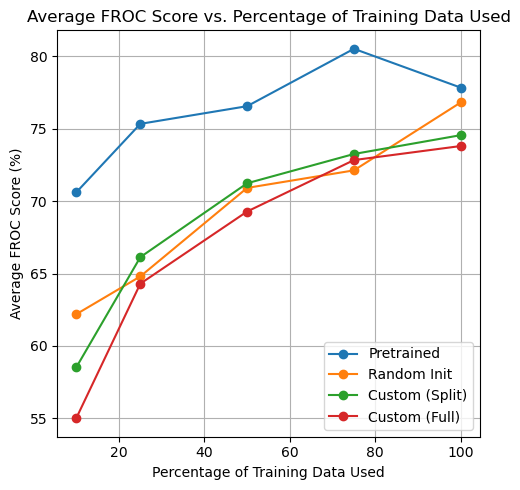

In [7]:
## Create line charts for results

import matplotlib.pyplot as plt
import numpy as np

results_froc = [
    [70.60, 75.33, 76.55, 80.51, 77.83],
    [62.19, 64.80, 70.91, 72.12, 76.81],
    [58.52, 66.13, 71.23, 73.25, 74.55],
    [55.01, 64.30, 69.28, 72.83, 73.80],
]

results_froc_2fp = [
    [81.52, 83.84, 85.34, 85.73, 87.29],
    [76.53, 76.83, 82.57, 83.21, 86.15],
    [68.74, 77.88, 82.02, 83.47, 85.08],
    [66.50, 77.42, 80.59, 84.14, 84.68],
]

results_map_05 = [
    [40.87, 46.14, 47.40, 47.45, 50.46],
    [31.88, 33.15, 41.71, 41.77, 49.13],
    [27.39, 34.87, 41.73, 44.52, 44.99],
    [24.60, 33.67, 40.92, 45.41, 44.89],
]

results_map_05_95 = [
    [15.40, 18.53, 19.19, 20.05, 22.82],
    [12.52, 13.39, 16.52, 16.32, 21.75],
    [9.53, 12.45, 16.28, 17.04, 18.94],
    [8.46, 11.96, 16.14, 18.31, 18.54],
]

x = [10, 25, 50, 75, 100]  # Percentages of training data used

labels = ["Pretrained", "Random Init", "Custom (Split)", "Custom (Full)"]

plt.figure(figsize=(5, 5))
for i, result in enumerate(results_froc):
    plt.plot(x, result, label=labels[i], marker='o')

plt.xlabel("Percentage of Training Data Used")
plt.ylabel("Average FROC Score (%)")
plt.title("Average FROC Score vs. Percentage of Training Data Used")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

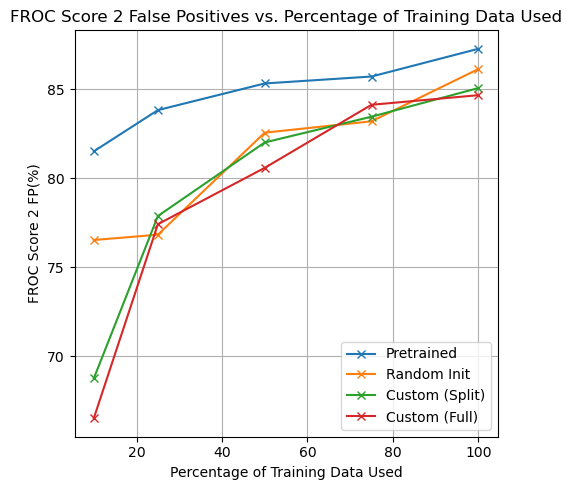

In [8]:
plt.figure(figsize=(5, 5))
for i, result in enumerate(results_froc_2fp):
    plt.plot(x, result, label=labels[i], marker='x')

plt.xlabel("Percentage of Training Data Used")
plt.ylabel("FROC Score 2 FP(%)")
plt.title("FROC Score 2 False Positives vs. Percentage of Training Data Used")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

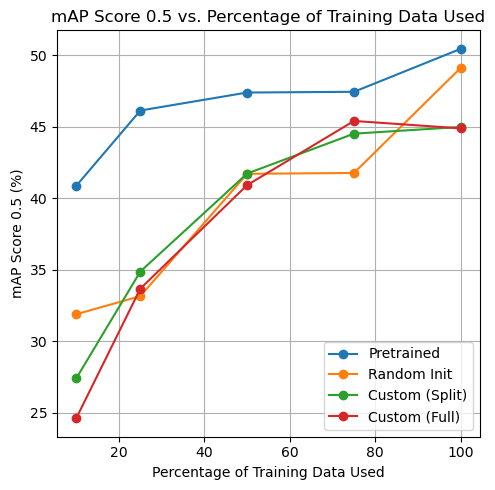

In [9]:
plt.figure(figsize=(5, 5))
for i, result in enumerate(results_map_05):
    plt.plot(x, result, label=labels[i], marker='o')

plt.xlabel("Percentage of Training Data Used")
plt.ylabel("mAP Score 0.5 (%)")
plt.title("mAP Score 0.5 vs. Percentage of Training Data Used")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

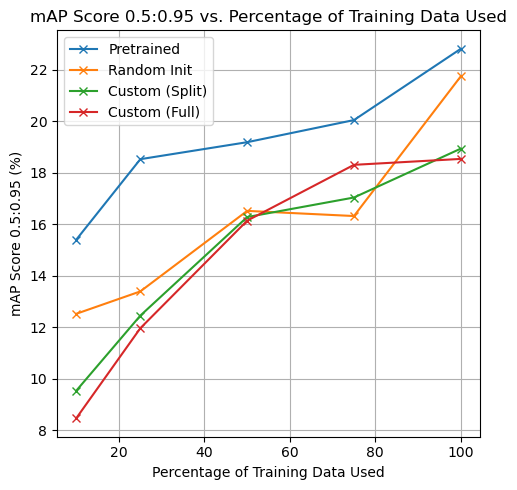

In [10]:
plt.figure(figsize=(5, 5))
for i, result in enumerate(results_map_05_95):
    plt.plot(x, result, label=labels[i], marker='x')

plt.xlabel("Percentage of Training Data Used")
plt.ylabel("mAP Score 0.5:0.95 (%)")
plt.title("mAP Score 0.5:0.95 vs. Percentage of Training Data Used")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

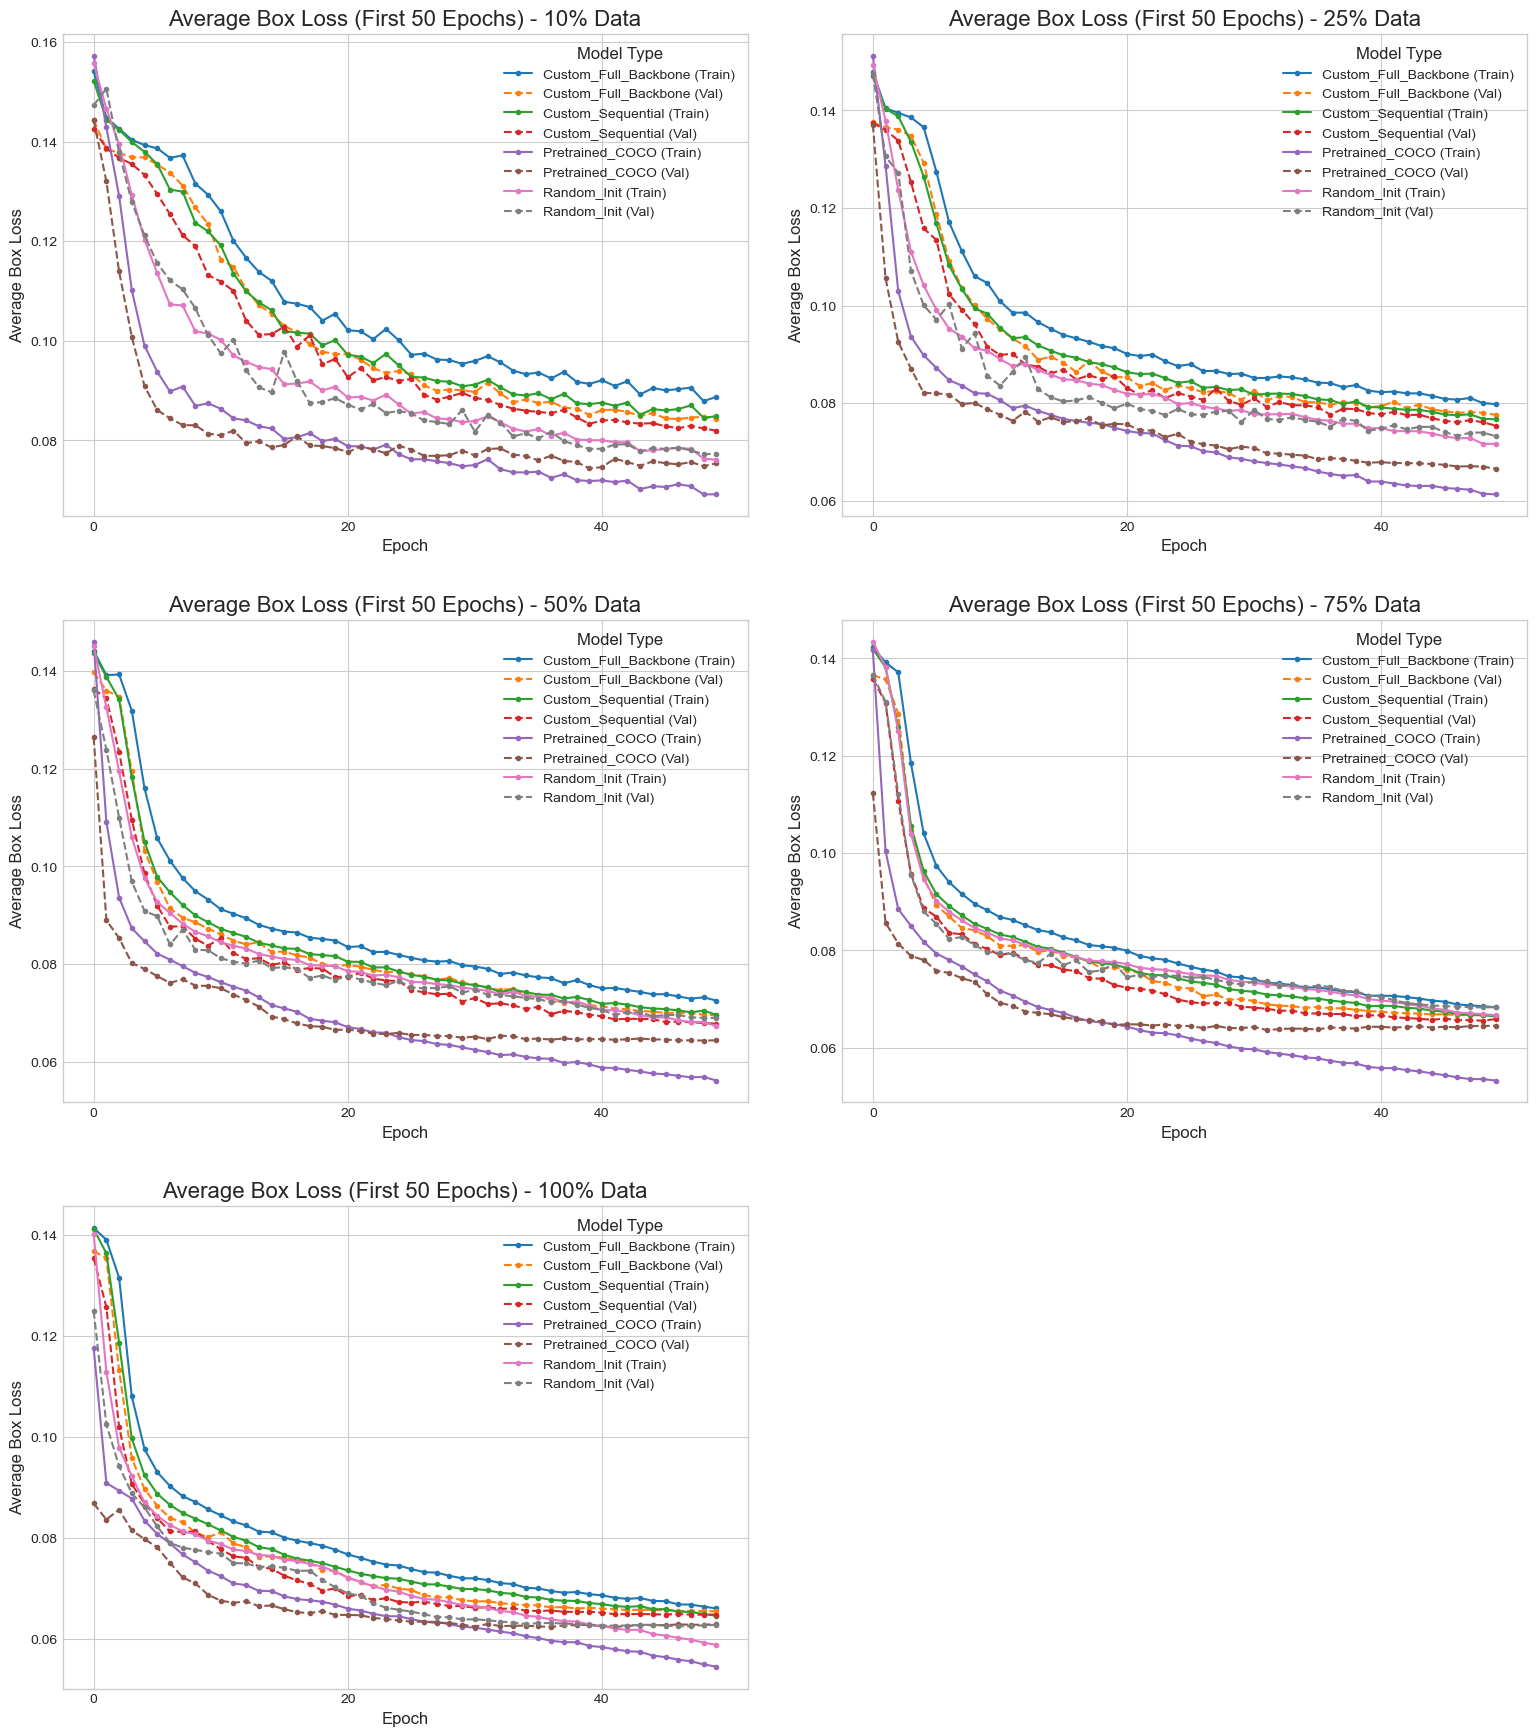

In [11]:
import os
import numpy as np
import pandas as pd

experiments_to_run = [
    # 10% Data Experiments
    {'name': 'Custom_Sequential', 'data_p': 10, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_backbone_sequential_0.002lr_data_percentage_comparison_p10"},
    {'name': 'Custom_Full_Backbone', 'data_p': 10, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_full_backbone_0.002lr_data_percentage_comparison_p10"},
    {'name': 'Pretrained_COCO', 'data_p': 10, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_pretrained_backbone_0.002lr_data_percentage_comparison_p10"},
    {'name': 'Random_Init', 'data_p': 10, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_random_backbone_0.01lr_data_percentage_comparison_p10"},

    # 25% Data Experiments
    {'name': 'Custom_Sequential', 'data_p': 25, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_backbone_sequential_0.002lr_data_percentage_comparison_p25"},
    {'name': 'Custom_Full_Backbone', 'data_p': 25, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_full_backbone_0.002lr_data_percentage_comparison_p25"},
    {'name': 'Pretrained_COCO', 'data_p': 25, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_pretrained_backbone_0.002lr_data_percentage_comparison_p25"},
    {'name': 'Random_Init', 'data_p': 25, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_random_backbone_0.01lr_data_percentage_comparison_p25"},

    # 50% Data Experiments
    {'name': 'Custom_Sequential', 'data_p': 50, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_backbone_sequential_0.002lr_data_percentage_comparison_p50"},
    {'name': 'Custom_Full_Backbone', 'data_p': 50, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_full_backbone_0.002lr_data_percentage_comparison_p50"},
    {'name': 'Pretrained_COCO', 'data_p': 50, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_pretrained_backbone_0.002lr_data_percentage_comparison_p50"},
    {'name': 'Random_Init', 'data_p': 50, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_random_backbone_0.01lr_data_percentage_comparison_p50"},

    # 75% Data Experiments
    {'name': 'Custom_Sequential', 'data_p': 75, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_backbone_sequential_0.002lr_data_percentage_comparison_p75"},
    {'name': 'Custom_Full_Backbone', 'data_p': 75, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_full_backbone_0.002lr_data_percentage_comparison_p75"},
    {'name': 'Pretrained_COCO', 'data_p': 75, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_pretrained_backbone_0.002lr_data_percentage_comparison_p75"},
    {'name': 'Random_Init', 'data_p':75, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_random_backbone_0.01lr_data_percentage_comparison_p75"},

    # 100% Data Experiments
    {'name': 'Custom_Sequential', 'data_p': 100, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_backbone_sequential_0.002lr"},
    {'name': 'Custom_Full_Backbone', 'data_p': 100, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_custom_full_backbone_0.002lr_p100"},
    {'name': 'Random_Init', 'data_p': 100, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output_random_init"},
    {'name': 'Pretrained_COCO', 'data_p': 100, 'path': r"C:\Users\peter\Masters\Project\LUNA16\yolov5_output"},
]

all_epoch_losses_train = defaultdict(list)
all_epoch_losses_val = defaultdict(list)

for run_info in experiments_to_run:
    model_name = run_info['name']
    data_p = run_info['data_p']
    base_path = run_info['path']

    for fold in range(10):
        # Dynamically build the path to the results.csv file
        try:
            if data_p < 100:
                results_path = os.path.join(base_path, f"fold_{fold}_p{data_p}", f"luna16_nodule_detection_p{data_p}", "results.csv")
            else:
                results_path = os.path.join(base_path, f"fold_{fold}", "luna16_nodule_detection", "results.csv")

            if not os.path.exists(results_path):
                print(f"  ⚠️  Warning: results.csv not found for {model_name} p{data_p} fold {fold}. Path checked: {results_path}")
                continue

            # Read the entire CSV for epoch data
            df_results = pd.read_csv(results_path)

            # Clean column names by stripping whitespace
            df_results.columns = df_results.columns.str.strip()

            experiment_key = (model_name, data_p)

            if 'train/box_loss' in df_results.columns:
                train_loss_numeric = pd.to_numeric(df_results['train/box_loss'], errors='coerce')
                all_epoch_losses_train[experiment_key].append(train_loss_numeric.head(50))
            else:
                print(f"Warning: 'train/box_loss' column not found in {results_path}")

            if 'val/box_loss' in df_results.columns:
                val_loss_numeric = pd.to_numeric(df_results['val/box_loss'], errors='coerce')
                all_epoch_losses_val[experiment_key].append(val_loss_numeric.head(50))
            else:
                print(f"Warning: 'val/box_loss' column not found in {results_path}")

        except Exception as e:
            print(f"Error processing {model_name} p{data_p} fold {fold}: {e}")


def average_losses_across_folds(all_epoch_losses):
    """Helper function to average loss series across all folds."""
    averaged_losses = {}
    for experiment_key, fold_losses_list in all_epoch_losses.items():
        if fold_losses_list:
            folds_df = pd.concat(fold_losses_list, axis=1)
            averaged_losses[experiment_key] = folds_df.mean(axis=1)
    return averaged_losses

averaged_losses_train = average_losses_across_folds(all_epoch_losses_train)
averaged_losses_val = average_losses_across_folds(all_epoch_losses_val)


if averaged_losses_train:
    df_plot_train = pd.DataFrame(averaged_losses_train)
    df_plot_val = pd.DataFrame(averaged_losses_val)

    # Get the unique data percentages to create a plot for each
    data_percentages = sorted(list(set(key[1] for key in averaged_losses_train.keys())))
    num_plots = len(data_percentages)
    ncols = 2
    # Calculate the number of rows needed
    nrows = (num_plots + ncols - 1) // ncols

    fig, axs = plt.subplots(nrows, ncols, figsize=(16, 6 * nrows), squeeze=False)
    axs = axs.flatten()

    # Set the plotting style
    plt.style.use('seaborn-v0_8-whitegrid')

    for i, dp in enumerate(data_percentages):
        ax = axs[i]

        models_for_dp = sorted([key[0] for key in averaged_losses_train.keys() if key[1] == dp])

        for model in models_for_dp:
            experiment_key = (model, dp)
            # Plot training loss
            if experiment_key in df_plot_train.columns:
                ax.plot(df_plot_train[experiment_key].index, df_plot_train[experiment_key].values, marker='.', linestyle='-', label=f'{model} (Train)')
            # Plot validation loss
            if experiment_key in df_plot_val.columns:
                 ax.plot(df_plot_val[experiment_key].index, df_plot_val[experiment_key].values, marker='.', linestyle='--', label=f'{model} (Val)')

        ax.set_title(f'Average Box Loss (First 50 Epochs) - {dp}% Data', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Average Box Loss', fontsize=12)
        ax.set_xticks(np.arange(0, 50, 20))
        ax.legend(title='Model Type', fontsize=10, title_fontsize=12)
        ax.grid(True)

    # Hide any unused subplots
    for i in range(num_plots, len(axs)):
        axs[i].set_visible(False)

    plt.tight_layout(pad=3.0)
    plt.show()

else:
    print("\nNo data was extracted for plotting.")

